<a href="https://colab.research.google.com/github/conorlime/CS6271/blob/main/GE%20Classification%20Problems%20Multitype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



#**Artificial Intelligence - MSc**
##CS6271 - Evolutionary Agorithms and Humanoid Robotics 
###GRAPE code running classification problems


Leader: Conor Ryan

Developer: Allan De Lima

Tester: Enrique Naredo

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Clone this repository in which we have all functions and classes created or adapted to this work.

In [2]:
import os.path
# Get the library from our BDS research Group
PATH = '/content/drive/MyDrive/grape/'
if os.path.exists(PATH):
    print('grape directory already exists')
else:
    %cd /content/drive/MyDrive/
    !git clone https://github.com/UL-BDS/grape.git
    print('Cloning grape in your Drive')

%cd /content/drive/MyDrive/grape/

/content/drive/MyDrive
Cloning into 'grape'...
remote: Enumerating objects: 92, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (62/62), done.
remote: Total 92 (delta 47), reused 70 (delta 28), pack-reused 0
Unpacking objects: 100% (92/92), done.
Cloning grape in your Drive
/content/drive/MyDrive/grape


Import adapted functions and classes from PonyGE2.

Import our algorithms, adapted from deap.algorithms.

Import DEAP (maybe it can be necessary to run the installation before that).

Import functions used by our grammars.



In [3]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [4]:
!pip install deap==1.3 

from ponyge2_adapted_files import Grammar, ge
import algorithms
from functions import add, sub, mul, pdiv, neg, and_, or_, not_, less_than_or_equal, greater_than_or_equal

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from deap import creator, base, tools

from sklearn.model_selection import train_test_split

Set our Grammatical Evolution parameters.

In [5]:
POPULATION_SIZE = 1000
MAX_GENERATIONS = 200
P_CROSSOVER = 0.8
P_MUTATION = 0.01
ELITE_SIZE = round(0.01*POPULATION_SIZE)

HALL_OF_FAME_SIZE = 1
MAX_INIT_TREE_DEPTH = 10
MIN_INIT_TREE_DEPTH = 2
MAX_TREE_DEPTH = 17
MAX_WRAPS = 0
CODON_SIZE = 255

Set a problem to solve. We can choose 'spambase' or 'heartDisease'.

In [6]:
problem = 'heartDisease'

Read datasets and grammars according to the problem picked in the previous cell.

In [7]:
if problem == 'spambase':
    X = np.zeros([4601, 57], dtype=float)
    Y = np.zeros([4601,], dtype=int)

    data = pd.read_table(r"datasets/spambase.csv")
    for i in range(4601):
        for j in range(57):
            X[i,j] = data['d'+ str(j)].iloc[i]
    for i in range(4601):
        Y[i] = data['class'].iloc[i]
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
        
    GRAMMAR_FILE = 'spambase.bnf'

elif problem == 'heartDisease':
    #There are 297 samples
    #We'll split into 70% for training and 30% for test, assuring the balanced data
    
    data =  pd.read_csv(r"datasets/processed.cleveland.data", sep=",")
    #There are some data missing on columns d11 and d12, so let's remove the rows
    data = data[data.ca != '?']
    data = data[data.thal != '?']
    
    #There are 160 samples with class 0, 54 with class 1, 35 with class 2,
    #35 with class 3 and 13 with class 4
    #Let's consider the class 0 and all the remaining as class 1
    Y = data['class'].to_numpy()
    for i in range(len(Y)):
        Y[i] = 1 if Y[i] > 0 else 0
    data = data.drop(['class'], axis=1)

    #Normalising numeric data    
    data.loc[:, ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] = (data.loc[:, ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']] - data.loc[:, ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].mean())/data.loc[:, ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']].std()
    
    #Using oneHot encoding on categorical (non binary) features
    data = pd.get_dummies(data, columns=['cp', 'restecg', 'slope', 'ca', 'thal'])
    
    X = data.to_numpy()
        
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
    
    X_train = np.transpose(X_train)
    X_test = np.transpose(X_test)
        
    GRAMMAR_FILE = 'heartDisease.bnf'

#Preprocessing the heart disease dataset

- Remove rows with missing data
- Consider all unhealthy classes as '1'
- Normalise numeric data
- Use One-Hot encoding in non-binary categorical data




#Attribute information about the heart disease dataset

Numeric attributes:
- age: age in years
- trestbps: esting blood pressure (in mm Hg on admission to the hospital)
- chol: serum cholestoral in mg/dl
- thalach: maximum heart rate achieved 
- oldpeak: ST depression induced by exercise relative to rest

Boolean attributes:
- sex: (1 = male; 0 = female)
- fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)       
- exang: exercise induced angina (1 = yes; 0 = no)    

Categorical (non binary) attributes:
- cp: chest pain type
 - Value 1: typical angina
 - Value 2: atypical angina
 - Value 3: non-anginal pain
 - Value 4: asymptomatic        
- restecg: resting electrocardiographic results
 - Value 0: normal
 - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
 - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria   
- slope: the slope of the peak exercise ST segment
 - Value 1: upsloping
 - Value 2: flat
 - Value 3: downsloping     
 
- ca: number of major vessels (0-3) colored by flourosopy        
- thal: 3 = normal; 6 = fixed defect; 7 = reversable defect      


The predicted attribute: diagnosis of heart disease (angiographic disease tatus)
- Value 0: < 50% diameter narrowing
- Value 1: > 50% diameter narrowing

Print data.

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

data.head()

,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,ca_0.0,ca_1.0,ca_2.0,ca_3.0,thal_3.0,thal_6.0,thal_7.0
0,0.934603,1.0,0.749116,-0.275978,1.0,0.017465,0.0,1.067164,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
1,1.376605,1.0,1.593577,0.743301,0.0,-1.813274,1.0,0.381130,0,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0
2,1.376605,1.0,-0.658320,-0.352904,0.0,-0.897904,1.0,1.324427,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,-1.938409,1.0,-0.095345,0.050961,0.0,1.630258,0.0,2.096215,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0
4,-1.496407,0.0,-0.095345,-0.833696,0.0,0.976423,0.0,0.295376,0,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0


Print grammar.

In [9]:
f = open("grammars/" + GRAMMAR_FILE, "r")
print(f.read())
f.close() 

<log_op> ::= <conditional_branches> | and_(<log_op>,<log_op>) | or_(<log_op>,<log_op>) | not_(<log_op>) | <boolean_feature>
<conditional_branches> ::= less_than_or_equal(<num_op>,<num_op>) | greater_than_or_equal(<num_op>, <num_op>)
<num_op>   ::= add(<num_op>,<num_op>) | sub(<num_op>,<num_op>) | mul(<num_op>,<num_op>) | pdiv(<num_op>,<num_op>) | <nonboolean_feature>
<boolean_feature> ::= x[1]|x[4]|x[6]|x[8]|x[9]|x[10]|x[11]|x[12]|x[13]|x[14]|x[15]|x[16]|x[17]|x[18]|x[19]|x[20]|x[21]|x[22]|x[23]|x[24]
<nonboolean_feature> ::= x[0]|x[2]|x[3]|x[5]|x[7]|<c><c>.<c><c>
<c>  ::= 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9



Set up the grammar addressed by GRAMMAR_FILE in the class Grammar.

In [10]:
BNF_GRAMMAR = Grammar(path.join("grammars", GRAMMAR_FILE))

Define as fitness function the number of outputs wrongly predicted.

In [11]:
def fitness_eval(individual, points):
    x = points[0]
    Y = points[1]
    
    if individual.invalid == True:
        return np.NaN,

    # Evaluate the expression
    try:
        pred = eval(individual.phenotype)
    except (FloatingPointError, ZeroDivisionError, OverflowError,
            MemoryError):
        # FP err can happen through eg overflow (lots of pow/exp calls)
        # ZeroDiv can happen when using unprotected operators
        return np.NaN,
    assert np.isrealobj(pred)
    
    try:
        Y_class = [1 if pred[i] > 0 else 0 for i in range(len(Y))]
    except (IndexError, TypeError):
        return np.NaN,

    compare = np.equal(Y,Y_class)
    fitness = 1 - np.mean(compare)
   
    return fitness,

Create the deap toolbox.

Use negative weights in the `base.Fitness` since we are trying to minimise the fitness.

`ge.Individual` is a class with the following attributes: `phenotype`, `genome`, `tree`, `nodes`, `invalid` (True or False), `depth` and `used_codons`.

Usually, when using deap, we initialise each individual independently, and then we repeat that until we fill out the whole population. However, since we are using Position Independent Grow Initialisation, we need to initialise all individuals simultaneously.

`ge.selTournament` prevents selecting invalid individuals.

`ge.crossover_onepoint` selects crossover points within the used portion of the genome. 

Similarly, `ge.mutation_int_flip_per_codon` performs only over the effective length.



In [12]:
toolbox = base.Toolbox()

# define a single objective, minimising fitness strategy:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

creator.create('Individual', ge.Individual, fitness=creator.FitnessMin)

toolbox.register("populationCreator", ge.initialisation_PI_Grow, creator.Individual) 

toolbox.register("evaluate", fitness_eval)

# Tournament selection:
toolbox.register("select", ge.selTournament, tournsize=7)

# Single-point crossover:
toolbox.register("mate", ge.crossover_onepoint)

# Flip-int mutation:
toolbox.register("mutate", ge.mutation_int_flip_per_codon)


Set the main function and run it.

Set the statistics object regarding the fitness score, but there are other statistics defined internally.

Perform Grammatical Evolution using `algorithms.ge_eaSimple`, a simple evolutionary algorithm. The differences to the `algorithms.eaSimple` used by deap are:

*   We use elitism;
*   After crossover and mutation, we check the offspring to assure that the max tree depth is not achieved;
*   We measure the generation and the selection times;
*   We count the number of invalid individuals.

In [13]:
# create initial population (generation 0):
population = toolbox.populationCreator(size=POPULATION_SIZE, 
                                        bnf_grammar=BNF_GRAMMAR, 
                                        min_init_tree_depth=MIN_INIT_TREE_DEPTH,
                                        max_init_tree_depth=MAX_INIT_TREE_DEPTH,
                                        max_tree_depth=MAX_TREE_DEPTH, 
                                        max_wraps=MAX_WRAPS,
                                        codon_size=CODON_SIZE
                                        )

# define the hall-of-fame object:
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

# prepare the statistics object:
stats = tools.Statistics(key=lambda ind: ind.fitness.values)
stats.register("avg", np.nanmean)
stats.register("std", np.nanstd)
stats.register("min", np.nanmin)
stats.register("max", np.nanmax)

# perform the Grammatical Evolution flow:
population, logbook = algorithms.ge_eaSimpleWithElitism(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, elite_size=ELITE_SIZE,
                                          bnf_grammar=BNF_GRAMMAR, codon_size=CODON_SIZE, 
                                          max_tree_depth=MAX_TREE_DEPTH, max_wraps=MAX_WRAPS,
                                          points_train=[X_train, Y_train], 
                                          points_test=[X_test, Y_test], 
                                          stats=stats, halloffame=hof, verbose=True)

gen	invalid	avg     	std     	min     	max     	fitness_test	best_ind_length	avg_length	max_length	selection_time	generation_time
0  	0      	0.487913	0.104615	0.231884	0.768116	0.311111    	4              	46.372    	274       	0             	0.445618       
1  	498    	0.404623	0.13302 	0.231884	0.768116	0.311111    	4              	23.29     	247       	0.014159      	1.08307        
2  	127    	0.354799	0.156518	0.231884	0.768116	0.311111    	4              	12.937    	172       	0.0123909     	0.357388       
3  	120    	0.348101	0.172904	0.231884	0.768116	0.311111    	4              	11.748    	170       	0.0160971     	0.425639       
4  	120    	0.327514	0.171451	0.231884	0.768116	0.311111    	4              	10.605    	172       	0.0124686     	0.418146       
5  	107    	0.30867 	0.156794	0.231884	0.768116	0.311111    	4              	10.793    	172       	0.0121965     	0.928695       
6  	94     	0.32847 	0.17571 	0.231884	0.768116	0.311111    	4              	11.639    	17

Extract statistics and build a beautiful table.

In [14]:
max_fitness_values, mean_fitness_values = logbook.select("max", "avg")
min_fitness_values, std_fitness_values = logbook.select("min", "std")
fitness_test = logbook.select("fitness_test")
best_ind_length = logbook.select("best_ind_length")
avg_length = logbook.select("avg_length")
max_length = logbook.select("max_length")
selection_time = logbook.select("selection_time")
generation_time = logbook.select("generation_time")
gen, invalid = logbook.select("gen", "invalid")

header = ['gen', 'invalid', 'avg', 'std', 'min', 'max', 'fitness_test', 'best_ind_length', 'avg_length', 'max_length', 'selection_time', 'generation_time']

results = pd.DataFrame(list(zip(gen, invalid, mean_fitness_values, std_fitness_values, min_fitness_values, max_fitness_values, fitness_test, best_ind_length, avg_length, max_length, selection_time, generation_time)),
               columns = header)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 10000)
pd.set_option('display.colheader_justify', 'center')

display(results)

,gen,invalid,avg,std,min,max,fitness_test,best_ind_length,avg_length,max_length,selection_time,generation_time
0,0,0,0.487913,0.104615,0.231884,0.768116,0.311111,4,46.372,274,0.000000,0.445618
1,1,498,0.404623,0.133020,0.231884,0.768116,0.311111,4,23.290,247,0.014159,1.083073
2,2,127,0.354799,0.156518,0.231884,0.768116,0.311111,4,12.937,172,0.012391,0.357388
3,3,120,0.348101,0.172904,0.231884,0.768116,0.311111,4,11.748,170,0.016097,0.425639
4,4,120,0.327514,0.171451,0.231884,0.768116,0.311111,4,10.605,172,0.012469,0.418146
5,5,107,0.308670,0.156794,0.231884,0.768116,0.311111,4,10.793,172,0.012197,0.928695
6,6,94,0.328470,0.175710,0.231884,0.768116,0.311111,4,11.639,173,0.012243,0.407008
7,7,78,0.330734,0.179800,0.231884,0.768116,0.311111,4,12.412,174,0.011470,0.432316
8,8,78,0.325380,0.175180,0.231884,0.768116,0.311111,4,12.038,175,0.012417,0.435612
9,9,77,0.321745,0.172573,0.217391,0.768116,0.244444,73,11.791,177,0.011618,0.419000


Show the best individual as an expression.

In [15]:
print("Best individual: ")
print(hof.items[0].phenotype)
print()
print("Training Fitness: ", hof.items[0].fitness.values[0])
print()
print("Depth: ", hof.items[0].depth)
print()
print("Length of the genome: ", len(hof.items[0].genome))
print()
print(f'Used portion of the genome: {hof.items[0].used_codons/len(hof.items[0].genome):.2f}')
print()

Best individual: 
not_(and_(not_(not_(x[18])),not_(and_(or_(x[17],greater_than_or_equal(sub(mul(pdiv(x[5],x[3]),x[7]),x[5]), sub(x[0],x[7]))),or_(and_(x[17],x[11]),or_(and_(x[13],x[21]),or_(and_(x[16],x[21]),or_(or_(x[21],x[24]),greater_than_or_equal(mul(mul(pdiv(x[0],x[0]),pdiv(pdiv(x[7],x[3]),x[7])),mul(add(x[7],x[5]),sub(x[0],x[2]))), sub(03.93,x[3]))))))))))

Training Fitness:  0.14492753623188404

Depth:  17

Length of the genome:  658

Used portion of the genome: 0.14



Plot graph regarding the best individual in each generations considering the training set and the test set.

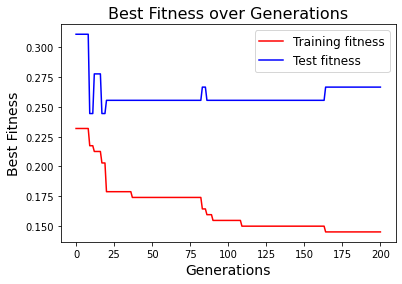

In [16]:
plt.plot(gen, min_fitness_values, color='red', label="Training fitness")
plt.plot(gen, fitness_test, color='blue', label="Test fitness")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Best Fitness', fontsize=14)
plt.title('Best Fitness over Generations', fontsize=16)
plt.show()


Plot graph regarding the average fitness in each generation considering the training set.

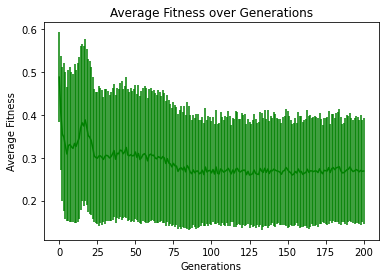

In [17]:
plt.xlabel('Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.errorbar(gen, mean_fitness_values, yerr=std_fitness_values,label="Best", color="Green")
plt.show()

Plot graphs regarding the length of the genome: the maximum value, the average of the population and that one of the best individual.


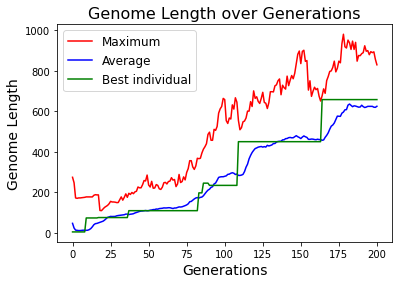

In [18]:
plt.plot(gen, max_length, color='red', label="Maximum")
plt.plot(gen, avg_length, color='blue', label="Average")
plt.plot(gen, best_ind_length, color='green', label="Best individual")
plt.legend(fontsize=12)
plt.xlabel('Generations', fontsize=14)
plt.ylabel('Genome Length', fontsize=14)
plt.title('Genome Length over Generations', fontsize=16)
plt.show()